In [1]:
import numpy as np
import json
from pprint import pprint

from collections import defaultdict
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()


import seaborn as sns

import sys
sys.path.append('/projects2/refer360test/src')
sys.path.append('/projects2/lxmert/src/')

import os
from tqdm import tqdm
from utils import rad2degree
from panoramic_camera import PanoramicCamera as camera

from utils import DIRECTIONS, CAT2LOC
from fov_pretraining import load_fovpretraining_splits, get_object_dictionaries
import cv2
import IPython

In [2]:
data_path='../../py_bottom_up_attention/demo/data/genome/1600-400-20'
vg_classes = []

with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
  for object in f.readlines():
    vg_classes.append(object.split(',')[0].lower().strip())

In [ ]:
splits = ['train']
#objects = 'table chair door television car table,chair,door,television,car'.split(' ')

data = {}
obj_dict_file = '../../data/vg_object_dictionaries.top50.json'
data_root = '../../data/balanced_fov_pretraining/'
vg2idx, idx2vg, obj_classes = get_object_dictionaries(obj_dict_file)

for d in DIRECTIONS:
  fovs, fov_files, regions, refexps,  obj_lists, \
    obj_queries, obj_directions, labels, pano_metas, _ = load_fovpretraining_splits(splits,d,
                                                                                 data_root =data_root,
                                                                                 obj_classes=obj_classes)
  data[d] = (labels,obj_classes)

In [ ]:
nrow = 1
ncols = len(DIRECTIONS)

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(18,18))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=10

ii = -1

topk = 50
obj_list = [line.strip().split(' ')[1]
              for line in open('../scripts/object_list.txt')][:topk]


for kk,d in enumerate(DIRECTIONS):

  directions = DIRECTIONS[d]
  

  
  datum = []
  labels = data[d][0]
  obj_classes = data[d][1]
  
  for d in directions:
    dlist = []
    for o_id in sorted(labels.keys()):
      dlist.append(labels[o_id][d])
    datum.append(dlist)
  datum = np.array(datum) 
  
  for column in range(datum.shape[1]):
    columnsum = sum(datum[:,column])
    for row in range(datum.shape[0]):
      datum[row,column] /= columnsum
      
  datum = datum.transpose()[:topk,:]
      
  axs[kk].imshow(datum)
  #axs[kk].set_title('{}'.format(c), fontsize=FONTSIZE)
  
  axs[kk].set_yticks(np.arange(len(obj_list)))
  axs[kk].set_xticks(np.arange(len(directions)))
  # ... and label them with the respective list entries
  axs[kk].set_yticklabels(obj_list,
                             fontsize=FONTSIZE)
  axs[kk].set_xticklabels(directions,
                             fontsize=FONTSIZE)

  # Rotate the tick labels and set their alignment.
  plt.setp(axs[kk].get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  
  for i in range(len(obj_list)):
      for j in range(len(directions)):
        #print(i,j,kk,len(obj_list),len(directions))
        text = axs[kk].text(j, i, '{:2.2f}'.format(datum[i, j]),
                              ha="center",
                              va="center",
                              color="w",
                             fontsize=FONTSIZE)
  
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)
fig.tight_layout()

plt.show()


In [ ]:
image_list = [line.strip()
              for line in open('../../data/imagelist.txt')]  
image_root = '../../data/refer360images'
graph_root = '../../data/graph_data/'

topk = 50
obj_list = [line.strip().split(' ')[1]
              for line in open('../scripts/object_list.txt')][:topk]

#pbar = tqdm(image_list)
pbar = image_list

node_list = []


pano_stats = {}
pano_stats['location'] = {}
pano_stats['category'] = {}
      
#vg2idx, idx2vg, obj_classes = get_objects_classes('../../data/vg_object_dictionaries.table,chair,door,television,car.json',
#                                                     data_path='../../py_bottom_up_attention/demo/data/genome/1600-400-20')

#obj_set = set('table,chair,door,television,car,bus,tree'.split(','))
#obj_list = list(obj_set)
obj_set = set(obj_list)
for fname in pbar:
  image_path = os.path.join(image_root, fname)
  pano = fname.split('/')[-1].split('.')[0]

  node_path = os.path.join(
      graph_root, '{}.npy'.format(pano))

  nodes = np.load(node_path,
                  allow_pickle=True)[()]
  node_list.append(nodes)
  
  pano_category = fname.split('/')[-2]
  pano_id = "_".join(fname.split(
        '/')[-1].split('.')[0].split('_')[:2])
  pano_loc = CAT2LOC[pano_category]
  
  for node in nodes:
    x = nodes[node]['x']
    y = nodes[node]['y']
    vg_obj_id = nodes[node]['obj_id']
    
    obj = vg_classes[vg_obj_id]
    if obj not in obj_set:
      continue

    if obj not in pano_stats['location']:
      pano_stats['location'][obj] = defaultdict(int)
      pano_stats['category'][obj] = defaultdict(int)

    pano_stats['category'][obj][pano_category] += 1.0
    pano_stats['location'][obj][pano_loc] += 1.0
          
#pbar.close()

In [ ]:
PANO={'location' : ['indoor','outdoor'],
     'category': CAT2LOC.keys()}

ncols = len(PANO)
nrow  = 1


fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(15,15))
fig.subplots_adjust(hspace = 0.1 ) 

FONTSIZE=8

ii = -1

for kk,cat in enumerate(PANO):

  categories = PANO[cat]
  
  labels = pano_stats[cat]

  datum = []
  for category in categories:
    dlist = []
    for obj in obj_list:
      dlist.append(labels[obj][category])
    datum.append(dlist)
  datum = np.array(datum)
  
  for column in range(datum.shape[1]):
    columnsum = sum(datum[:,column])
    for row in range(datum.shape[0]):
      datum[row,column] /= columnsum
  
  datum = datum.transpose()
  
  axs[kk].imshow(datum)
  #axs[kk].set_title('{}'.format(c), fontsize=FONTSIZE)
  
  axs[kk].set_xticks(np.arange(len(categories)))
  axs[kk].set_yticks(np.arange(len(obj_list)))
  # ... and label them with the respective list entries
  axs[kk].set_xticklabels(categories,
                             fontsize=FONTSIZE)
  axs[kk].set_yticklabels(obj_list,
                             fontsize=FONTSIZE)

  # Rotate the tick labels and set their alignment.
  plt.setp(axs[kk].get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  
  for i in range(len(obj_list)):
      for j in range(len(categories)):
          text = axs[kk].text(j, i, '{:2.2f}'.format(datum[i, j]),
                              ha="center",
                              va="center",
                              color="w",
                             fontsize=FONTSIZE)
  
  
plt.rc('xtick',labelsize=FONTSIZE)
plt.rc('ytick',labelsize=FONTSIZE)
fig.tight_layout()

plt.show()

In [ ]:
scale = 10
width = int(4552/scale)
height = int(2276/scale)
canvas = np.ones((height,width,3),dtype=np.uint8)*255

x1s = [300,1000,1000]
x2s = [400,1200,2000]
y1s = [300,1000,1000]
y2s = [400,1600,1200]

alpharange = np.arange(0, 1.1, 0.1)[::-1]

ncols = 1 
nrow  = len(alpharange)


fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(15,15))
fig.subplots_adjust(hspace = 0.1 ) 

for kk, alpha in enumerate(alpharange):
  print(alpha)
  canvas = np.ones((height,width,3),dtype=np.uint8)*255
  overlay = canvas.copy()
  
  for x1,x2,y1,y2 in zip(x1s,x2s,y1s,y2s):
    x1 = int(x1/scale)
    x2 = int(x2/scale)
    y1 = int(y1/scale)
    y2 = int(y2/scale)
    
    overlay[y1:y2,x1:x2,:] = 0
  
  cv2.addWeighted(overlay, alpha,
                  canvas, 1 - alpha,0,
                  canvas)
  axs[kk].imshow(canvas)

100%|██████████| 2000/2000 [00:53<00:00, 37.11it/s]


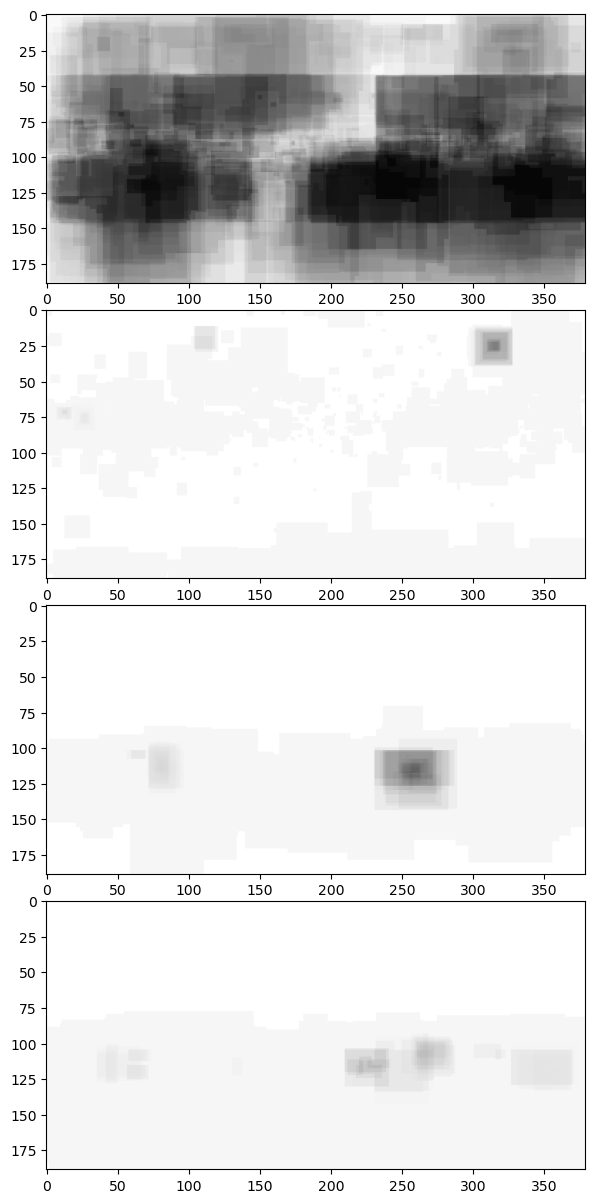

In [34]:
image_list = [line.strip()
              for line in open('../../data/imagelist.txt')]  
image_root = '../../data/refer360images'
graph_root = '../../data/graph_data/'

topk = 50
obj_list = [line.strip().split(' ')[1]
              for line in open('../scripts/object_list.txt')][:topk]

pbar = tqdm(image_list)

scale = 12
width = int(4552/scale)
height = int(2276/scale)
canvas = np.ones((height,width,3),dtype=np.uint8)*255

canvases = {}
canvases['all'] = canvas.copy()
canvases['object'] = {}
canvases['category'] = {}
      
obj_set = set(obj_list)
# alpha_small = 0.05
# alpha_large = 0.10

alpha_small = 0.050
alpha_large = 0.075
for fname in pbar:
  image_path = os.path.join(image_root, fname)
  pano = fname.split('/')[-1].split('.')[0]

  node_path = os.path.join(
      graph_root, '{}.npy'.format(pano))

  nodes = np.load(node_path,
                  allow_pickle=True)[()]
  
  pano_category = fname.split('/')[-2]
  pano_id = "_".join(fname.split(
        '/')[-1].split('.')[0].split('_')[:2])
  pano_loc = CAT2LOC[pano_category]
  
  overlay_all = canvas.copy()
  for node in nodes:
    x = nodes[node]['x']
    y = nodes[node]['y']
    
    box = nodes[node]['boxes']
    w = box[2] - box[0]
    h = box[3] - box[1]
    
    x1 = int((x - w/2)/scale)
    x2 = int((x + w/2)/scale)
    y1 = int((y - h/2)/scale)
    y2 = int((y + h/2)/scale)    
    
    vg_obj_id = nodes[node]['obj_id']
    
    obj = vg_classes[vg_obj_id]
    if obj not in obj_set:
      continue
  
    overlay_all[y1:y2,x1:x2,:] = 0
    overlay_obj = canvas.copy()
    overlay_obj[y1:y2,x1:x2,:] = 0

    if obj not in canvases['object']:
      canvases['object'][obj] = canvas.copy() 
      canvases['category'][obj] = { c: canvas.copy() for c in CAT2LOC.keys()}
    cv2.addWeighted(overlay_obj, alpha_small,
                  canvases['object'][obj], 1 - alpha_small,0,
                  canvases['object'][obj])
    cv2.addWeighted(overlay_obj, alpha_small,
                  canvases['category'][obj][pano_category], 1 - alpha_small,0,
                  canvases['category'][obj][pano_category])      
  cv2.addWeighted(overlay_all, alpha_large,
                  canvases['all'], 1 - alpha_large,0,
                  canvases['all'])
          
pbar.close()


canvas_list = [canvases['all'],
               canvases['object']['clock'],
               canvases['category']['table']['bedroom'],
               canvases['category']['table']['restaurant'],
              ]
ncols = 1 
nrow  = len(canvas_list)

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(15,15))
fig.subplots_adjust(hspace = 0.1 ) 

for kk, c in enumerate(canvas_list):
  axs[kk].imshow(c)

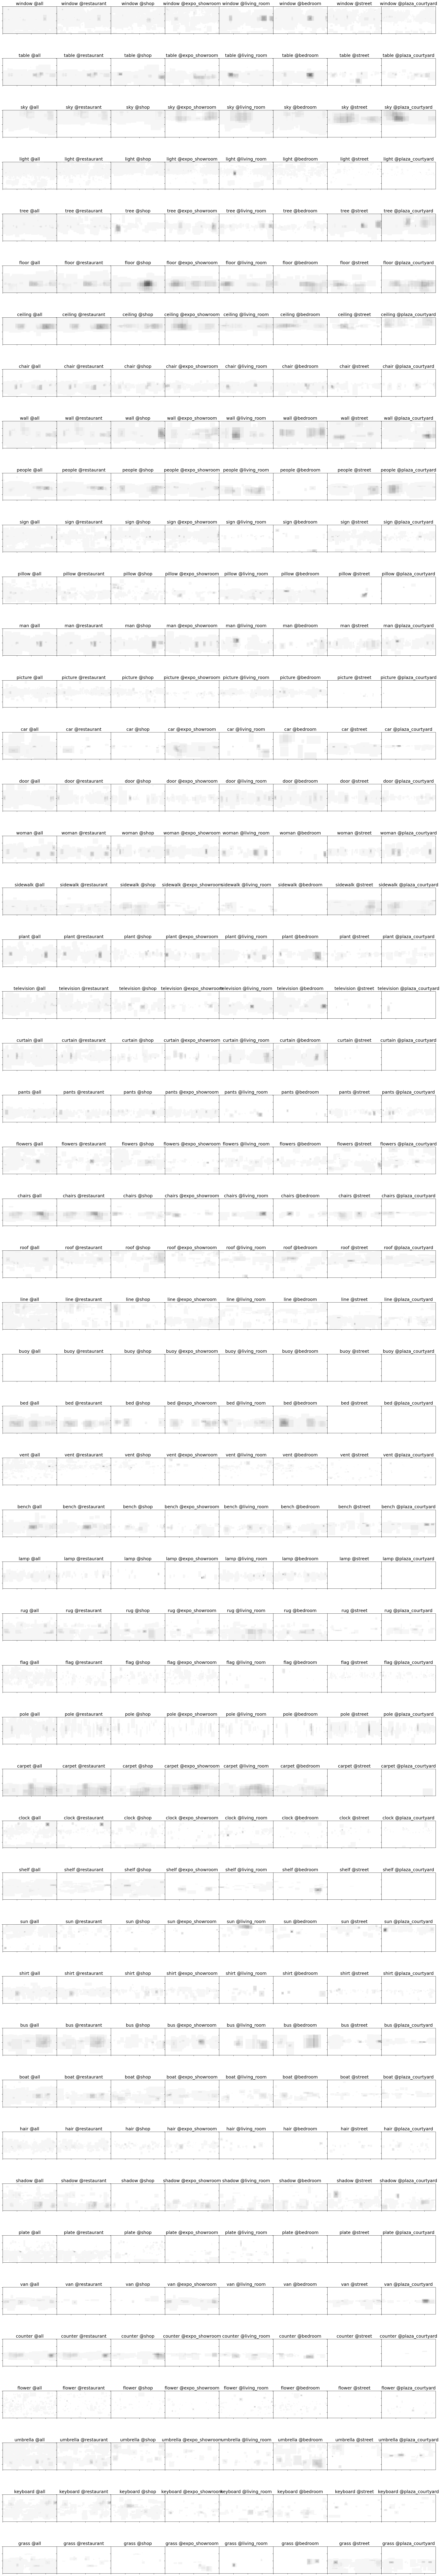

In [35]:
short = len(obj_list)
short_obj_list = obj_list[:short]
for obj in short_obj_list:
  canvases['category'][obj]['all'] = canvases['object'][obj]

cats = ['all'] + list(CAT2LOC.keys())
ncols = len(cats)
nrow  = len(short_obj_list)
FONTSIZE=18

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(32,192))
fig.subplots_adjust(hspace = 0.3,wspace = 0.0) 

for kk, obj in enumerate(short_obj_list):
  for jj, cat in enumerate(cats):
    axs[kk,jj].set_title('{} @{}'.format(obj,cat), fontsize=FONTSIZE)
    axs[kk,jj].imshow(canvases['category'][obj][cat])
    axs[kk,jj].set_xticklabels([])
    axs[kk,jj].set_yticklabels([])


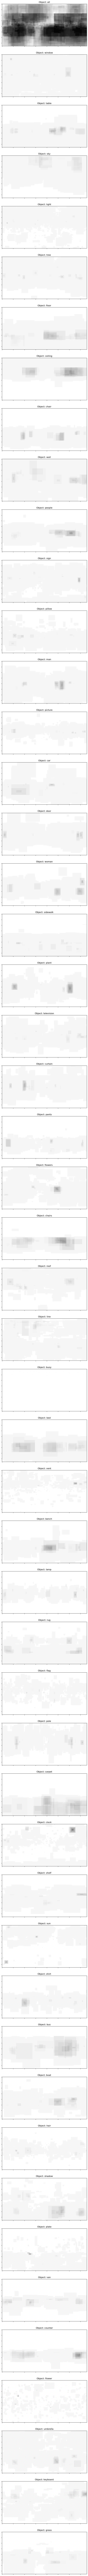

In [36]:
canvas_list = [(canvases['all'],'all')] + [(canvases['object'][obj],obj) for obj in obj_list]

ncols = 1 
nrow  = len(canvas_list)
FONTSIZE=12

fig, axs = plt.subplots(nrows=nrow, ncols=ncols, figsize=(256,256))
fig.subplots_adjust(hspace = 0.2,wspace=0) 

for kk, (c,obj) in enumerate(canvas_list):
  axs[kk].imshow(c)
  axs[kk].set_title('Object: {}'.format(obj), fontsize=FONTSIZE)
  axs[kk].set_xticklabels([])
  axs[kk].set_yticklabels([])
